In [25]:
%pip install ratelimit


  Preparing metadata (setup.py) ... done
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5895 sha256=8591ba88a08882987b047a4cf3ff415dca223b8ee8d6ca637e7bb647be5de394
  Stored in directory: /Users/julienmiquel/Library/Caches/pip/wheels/27/5f/ba/e972a56dcbf5de9f2b7d2b2a710113970bd173c4dcd3d2c902
Successfully built ratelimit

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:

import vertexai
from google.cloud import bigquery

PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")
client = bigquery.Client(project=PROJECT_ID)

%load_ext google.cloud.bigquery

In [2]:
%%bigquery  df_labels_embeddings


with results as (
      SELECT
      uri,  metadata_value as Id
      , string(json_extract(l, '$.description')) as description
      , float64(json_extract (l, '$.score')) as score

 FROM `ml-demo-384110.immo_us.image_cloudvision_results`  as ml_res 
    left join unnest(json_extract_array(label_annotations)) as l
) 

select       Id,    uri, description, score
FROM results where score >= 0.7
order by Id, uri, score








In [17]:
%%bigquery  df_labels


with results as (
      SELECT
      uri,  metadata_value as Id
      , string(json_extract(l, '$.description')) as description
      , float64(json_extract (l, '$.score')) as score

 FROM `ml-demo-384110.immo_us.image_cloudvision_results`  as ml_res 
    left join unnest(json_extract_array(label_annotations)) as l
) 

select       Id,    uri, description, score
FROM results where score >= 0.7
order by Id, uri, score








Downloading: 100%|██████████| 40507/40507 [00:02<00:00, 16731.68rows/s]


In [15]:
df_labels

,Id,uri,description,score
0,adapt-immo-3011433799,gs://ml-demo-384110-bucket/dataset/immo/images...,Comfort,0.812451
1,adapt-immo-3011433799,gs://ml-demo-384110-bucket/dataset/immo/images...,Chair,0.813601
2,adapt-immo-3011433799,gs://ml-demo-384110-bucket/dataset/immo/images...,Floor,0.838365
3,adapt-immo-3011433799,gs://ml-demo-384110-bucket/dataset/immo/images...,Building,0.841956
4,adapt-immo-3011433799,gs://ml-demo-384110-bucket/dataset/immo/images...,Flooring,0.845857
...,...,...,...,...
41046,visiteonline-p_5558326,gs://ml-demo-384110-bucket/dataset/immo/images...,Building,0.936861
41047,visiteonline-p_5558326,gs://ml-demo-384110-bucket/dataset/immo/images...,Window,0.941215
41048,visiteonline-p_5558326,gs://ml-demo-384110-bucket/dataset/immo/images...,Cloud,0.944998
41049,visiteonline-p_5558326,gs://ml-demo-384110-bucket/dataset/immo/images...,Sky,0.953072


In [40]:
%%bigquery  df_labels_agg_attributes

with results as (
      SELECT
      uri,  metadata_value as Id
      , string(json_extract(l, '$.description')) as description
      , float64(json_extract (l, '$.score')) as score

 FROM `ml-demo-384110.immo_us.image_cloudvision_results`  as ml_res 
    left join unnest(json_extract_array(label_annotations)) as l
) 

select           uri, STRING_AGG(description, ', ') attributes,
ml.
FROM results where score >= 0.7
group by uri
limit 400



Downloading: 100%|██████████| 400/400 [00:02<00:00, 170.14rows/s]


In [89]:
%%bigquery

create table `immo_us_enriched.image_cloudvision_labels_1k` as (

with results as (
      SELECT
      uri,  metadata_value as Id
      , string(json_extract(l, '$.description')) as description
      , float64(json_extract (l, '$.score')) as score

 FROM `ml-demo-384110.immo_us.image_cloudvision_results`  as ml_res 
    left join unnest(json_extract_array(label_annotations)) as l
) 


select           uri, STRING_AGG(description, ', ') attributes, Id

    from results
      where score >= 0.7
group by uri, Id
limit 1000
)
      ;



Query complete after 0.00s: 100%|██████████| 6/6 [00:00<00:00, 6006.16query/s]                        


""


In [ ]:
%%bigquery df_labels_agg_attributes_summary


select           * 

FROM
  ML.GENERATE_TEXT(
    MODEL `immo_us_enriched.bqml-llm_model`,
    (
      SELECT uri, attributes,
        CONCAT(
          #'Summarize in one word with based on real estate context based on CONTEXT: ',
'In one word, provide the lexical fields of CONTEXT: ',
#'In one word, summarize CONTEXT: ',

          attributes,
          " WORD:"
          ) AS prompt
      FROM `immo_us_enriched.image_cloudvision_labels` 
    ),
    STRUCT(
      0.2 AS temperature,
      10 AS max_output_tokens,
      0.1 AS top_p,
      10 AS top_k, TRUE AS flatten_json_output)) as ml_results;



In [94]:

%%bigquery 

create or replace table `immo_us_enriched.image_cloudvision_labels_1k_bench_3`  as  (
select           
ml_results.ml_generate_text_llm_result as location,
ml_generate_text_rai_result['blocked'] AS blocked,
ml_generate_text_rai_result['categories'] AS blocked_categories,
ml_generate_text_status,
uri,
attributes,
Id 
FROM
  ML.GENERATE_TEXT(
    MODEL `immo_us_enriched.bqml-llm_model`,
    (
      SELECT uri, attributes, Id,
        CONCAT(
#'Summarize in one word with based on real estate context based on CONTEXT: ',
#'In one word, provide the lexical fields of CONTEXT: ',
'Answer in one word. Describe where these attributes can be found in real estate place (place exemples: garden, kitchen, bedroom, living-room, garage, hall, laundry-room, bathroom, porch or floorplan). If the place is not clear answer "N/A" ATTRIBUTES: ',
          attributes,
          ". These attributes could be in place: "
          ) AS prompt
      FROM `immo_us_enriched.image_cloudvision_labels_1k` 
    ),
    STRUCT(
      0.2 AS temperature,
      10 AS max_output_tokens,
      1.0 AS top_p,
      1 AS top_k, 
      TRUE AS flatten_json_output)
      ) as ml_results
)

Executing query with job ID: edac2583-f839-4a5b-bdf1-99f43ee0972e
Query executing: 591.97s

## reduce attributes

In [85]:
from ratelimit import limits, sleep_and_retry

import requests


# [START aiplatform_sdk_embedding]
from vertexai.language_models import TextGenerationModel
generation_model = TextGenerationModel.from_pretrained("text-bison@001")
prompt_summarize = "summarize in one word: "

@sleep_and_retry
@limits(calls=1, period=60)
def summarize_text(text) -> list:
    
    result = generation_model.predict(
        prompt_summarize + text, temperature=0.2, max_output_tokens=3, top_k=1, top_p=0.8
    )

    return result.text

#df = df_labels_agg_attributes

df['summarize'] = df.attributes.map(  lambda attribute : summarize_text(attribute))


ServiceUnavailable: 503 Connection reset by peer

## Analyse with embeddings

In [41]:
from ratelimit import limits, sleep_and_retry

import requests


# [START aiplatform_sdk_embedding]
from vertexai.language_models import TextEmbeddingModel

@sleep_and_retry
@limits(calls=5, period=1)
def text_embedding(texts) -> list:
    """Text embedding with a Large Language Model."""
    model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
    embeddings = model.get_embeddings(texts)
    for embedding in embeddings:
        vector = embedding.values
        #print(f"Length of Embedding Vector: {len(vector)}")
    # [END aiplatform_sdk_embedding]
    return vector

df = df_labels_agg_attributes

df['embeddings'] = df.attributes.map(  lambda attribute:text_embedding([attribute]))


In [42]:
df.describe()

,uri,attributes,embeddings
count,400,400,400
unique,400,394,394
top,gs://ml-demo-384110-bucket/dataset/immo/images...,"Cabinetry, Countertop, Property, Kitchen appli...","[-0.04963044077157974, 0.03163569048047066, 0...."
freq,1,2,2


In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

cos_sim_array = cosine_similarity(list(df.embeddings.values))

# display as DataFrame
df_matrix = pd.DataFrame(cos_sim_array, index=df.attributes, columns=df.attributes)
df_matrix

attributes,"Plant, Sky, Cloud, Natural landscape, Tree, Land lot, Highland, Grass, Shrub, Landscape","Plant, Sky, Land lot, Grass, Tree, Road surface, Landscape, Road, Stone wall, Brick","Plant, Building, Sky, Property, Window, Cloud, House, Land lot, Tree, Grass","Plant, Sky, Cloud, Property, Road surface, Natural landscape, Land lot, Tree, Grass, Landscape","Parallel, Font, Rectangle","Plant, Cloud, Sky, Natural landscape, Branch, Tree, Shade, Grass, Shrub, Landscape","Plant, Sky, Cloud, Plant community, Tree, Natural landscape, Shade, Shrub, Grass, Landscape","Plant, Plant community, Vegetation, Terrestrial plant, Natural landscape, Grass, Shrub, Forest, Landscape","Cloud, Plant, Sky, Building, Window, Natural landscape, Branch, Land lot, Grass, Tree","Plant, Building, Land lot, Road surface, Window, Natural landscape, Tree, House, Shade, Landscape","Water, Sky, Plant, Cloud, Plant community, Natural landscape, Lake, Fluvial landforms of streams, Body of water, Lacustrine plain","Sky, Building, Window, Cloud, Urban design, Tree, Condominium, Neighbourhood, Tower block, Material property","Cloud, Sky, Building, Tree, Urban design, Tower block, Condominium, Window, Facade, City","Cloud, Sky, Plant, Property, Building, Tree, Window, House, Natural landscape, Land lot","Cloud, Plant, Sky, Building, Tree, House, Road surface, Larch, Asphalt, Natural landscape","Plant, Building, Window, House, Tree, Land lot, Grass, Sky, Cottage, Residential area","Building, Sky, Daytime, Plant, Property, Skyscraper, Window, Tower block, Cloud, Tree","Tire, Sky, Wheel, Land vehicle, Plant, Car, Vehicle, Window, Motor vehicle, Building","Plant, Building, Window, Tree, Architecture, Land lot, Urban design, Residential area, Real estate, Grass","Plant, Sky, Cloud, Building, Tree, Land lot, Window, House, Stairs, Residential area"
attributes,,,,,,,,,,,,,,,,,,,,
"Plant, Sky, Cloud, Natural landscape, Tree, Land lot, Highland, Grass, Shrub, Landscape",1.000000,0.893536,0.890882,0.948374,0.642203,0.935086,0.931552,0.864581,0.912058,0.855507,0.891558,0.829753,0.817142,0.912738,0.892860,0.841608,0.841535,0.788991,0.831077,0.872679
"Plant, Sky, Land lot, Grass, Tree, Road surface, Landscape, Road, Stone wall, Brick",0.893536,1.000000,0.903943,0.948898,0.667675,0.860450,0.849113,0.804097,0.900723,0.904910,0.815993,0.823510,0.818459,0.894836,0.917218,0.833547,0.867024,0.845400,0.839520,0.878096
"Plant, Building, Sky, Property, Window, Cloud, House, Land lot, Tree, Grass",0.890882,0.903943,1.000000,0.927980,0.627113,0.861483,0.857919,0.783627,0.952380,0.889015,0.802288,0.893061,0.868495,0.966619,0.901651,0.925413,0.926796,0.875289,0.905116,0.942789
"Plant, Sky, Cloud, Property, Road surface, Natural landscape, Land lot, Tree, Grass, Landscape",0.948374,0.948898,0.927980,1.000000,0.633832,0.912730,0.901847,0.829509,0.926322,0.899054,0.862105,0.843618,0.828490,0.937605,0.932755,0.844401,0.871714,0.821257,0.844088,0.892539
"Parallel, Font, Rectangle",0.642203,0.667675,0.627113,0.633832,1.000000,0.637720,0.609729,0.635427,0.626698,0.646675,0.609762,0.624574,0.641452,0.626561,0.637503,0.635248,0.632567,0.656109,0.646862,0.636611
"Plant, Cloud, Sky, Natural landscape, Branch, Tree, Shade, Grass, Shrub, Landscape",0.935086,0.860450,0.861483,0.912730,0.637720,1.000000,0.955028,0.848242,0.917625,0.836750,0.876442,0.824001,0.822151,0.876049,0.882813,0.811579,0.837442,0.757857,0.807704,0.855901
"Plant, Sky, Cloud, Plant community, Tree, Natural landscape, Shade, Shrub, Grass, Landscape",0.931552,0.849113,0.857919,0.901847,0.609729,0.955028,1.000000,0.899481,0.882982,0.833323,0.902840,0.816442,0.806151,0.867956,0.861005,0.816251,0.832188,0.744811,0.805735,0.849937
"Plant, Plant community, Vegetation, Terrestrial plant, Natural landscape, Grass, Shrub, Forest, Landscape",0.864581,0.804097,0.783627,0.829509,0.635427,0.848242,0.899481,1.000000,0.775583,0.805683,0.848974,0.737090,0.733168,0.786247,0.796049,0.776034,0.767881,0.729254,0.786238,0.763739
"Cloud, Plant, Sky, Buil

[Text(0.5, 1, 'Plant, Sky, Cloud, Natural landscape, Tree, Land lot, Highland, Grass, Shrub, Landscape'),
 Text(1.5, 1, 'Plant, Sky, Land lot, Grass, Tree, Road surface, Landscape, Road, Stone wall, Brick'),
 Text(2.5, 1, 'Plant, Building, Sky, Property, Window, Cloud, House, Land lot, Tree, Grass'),
 Text(3.5, 1, 'Plant, Sky, Cloud, Property, Road surface, Natural landscape, Land lot, Tree, Grass, Landscape'),
 Text(4.5, 1, 'Parallel, Font, Rectangle'),
 Text(5.5, 1, 'Plant, Cloud, Sky, Natural landscape, Branch, Tree, Shade, Grass, Shrub, Landscape'),
 Text(6.5, 1, 'Plant, Sky, Cloud, Plant community, Tree, Natural landscape, Shade, Shrub, Grass, Landscape'),
 Text(7.5, 1, 'Plant, Plant community, Vegetation, Terrestrial plant, Natural landscape, Grass, Shrub, Forest, Landscape'),
 Text(8.5, 1, 'Cloud, Plant, Sky, Building, Window, Natural landscape, Branch, Land lot, Grass, Tree'),
 Text(9.5, 1, 'Plant, Building, Land lot, Road surface, Window, Natural landscape, Tree, House, Shade,

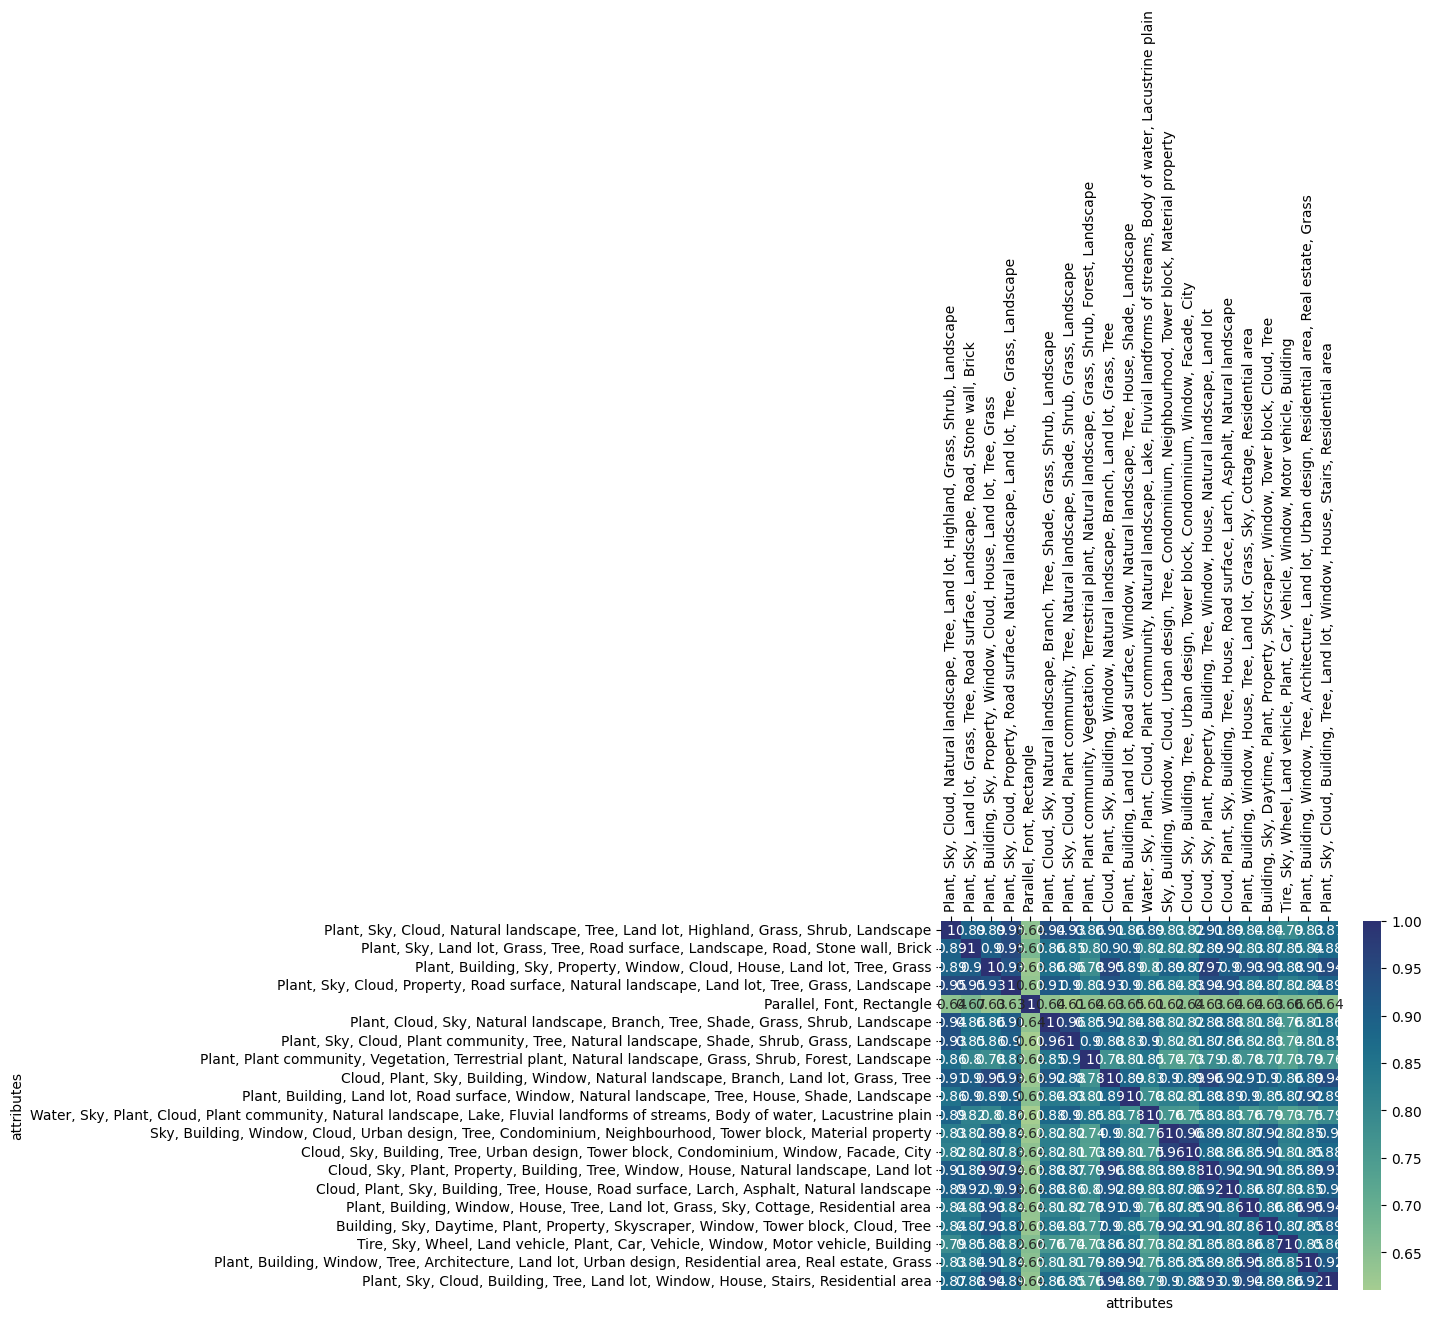

In [35]:
import seaborn as sns

ax = sns.heatmap(df_matrix, annot=True, cmap="crest")
ax.xaxis.tick_top()
ax.set_xticklabels(df.attributes, rotation=90)

In [ ]:
from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
#tsne = TSNE(random_state=1, n_iter=300, metric="cosine")

#embs = tsne.fit_transform(df)
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]



In [47]:
df['x']  = df['embeddings'].map(lambda l : l[0])
df['y']  = df['embeddings'].map(lambda l : l[1])

In [ ]:
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


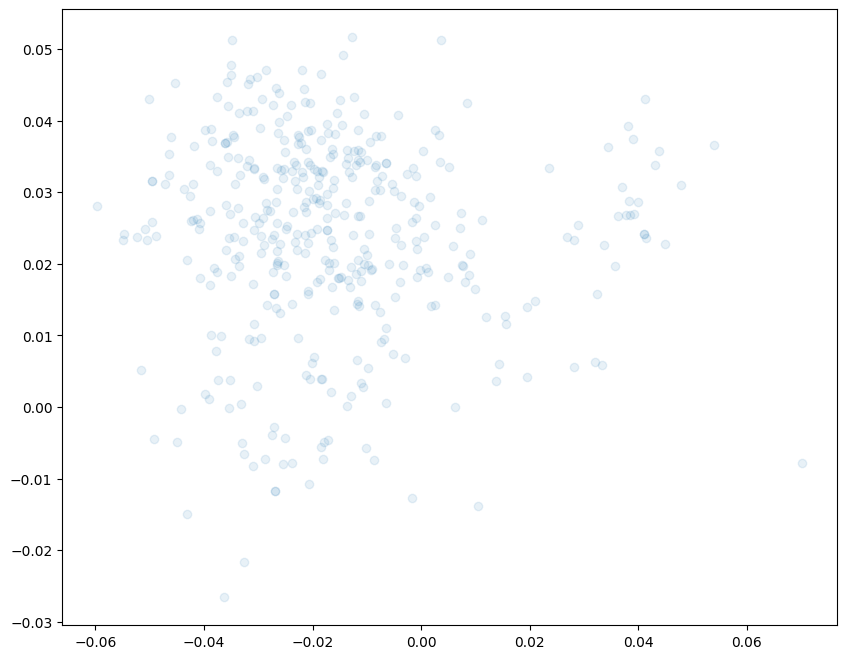

In [49]:


FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

In [80]:
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = df['embeddings']
    fig, ax = plt.subplots(figsize=figsize)
    X = df['x']
    Y = df['y']
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.attributes.str.contains(pattern)]
    print(f"find: {match.count}")
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
#    if emb_2d is None:
#        emb_2d = df['embeddings']

    X = df['x'][label_indices]
    Y = df['y'][label_indices]

#    X = emb_2d[label_indices, 0]
#    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = df['x'][label_indices]
    Ylabeled = df['y'][label_indices]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = df.loc[label_indices, 'attributes'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.attributes.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.attributes == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)
# This and se

find: <bound method DataFrame.count of                                                    uri  \
7    gs://ml-demo-384110-bucket/dataset/immo/images...   
25   gs://ml-demo-384110-bucket/dataset/immo/images...   
28   gs://ml-demo-384110-bucket/dataset/immo/images...   
31   gs://ml-demo-384110-bucket/dataset/immo/images...   
65   gs://ml-demo-384110-bucket/dataset/immo/images...   
68   gs://ml-demo-384110-bucket/dataset/immo/images...   
71   gs://ml-demo-384110-bucket/dataset/immo/images...   
106  gs://ml-demo-384110-bucket/dataset/immo/images...   
131  gs://ml-demo-384110-bucket/dataset/immo/images...   
139  gs://ml-demo-384110-bucket/dataset/immo/images...   
151  gs://ml-demo-384110-bucket/dataset/immo/images...   
153  gs://ml-demo-384110-bucket/dataset/immo/images...   
154  gs://ml-demo-384110-bucket/dataset/immo/images...   
160  gs://ml-demo-384110-bucket/dataset/immo/images...   
168  gs://ml-demo-384110-bucket/dataset/immo/images...   
178  gs://ml-demo-384110-bucket/d

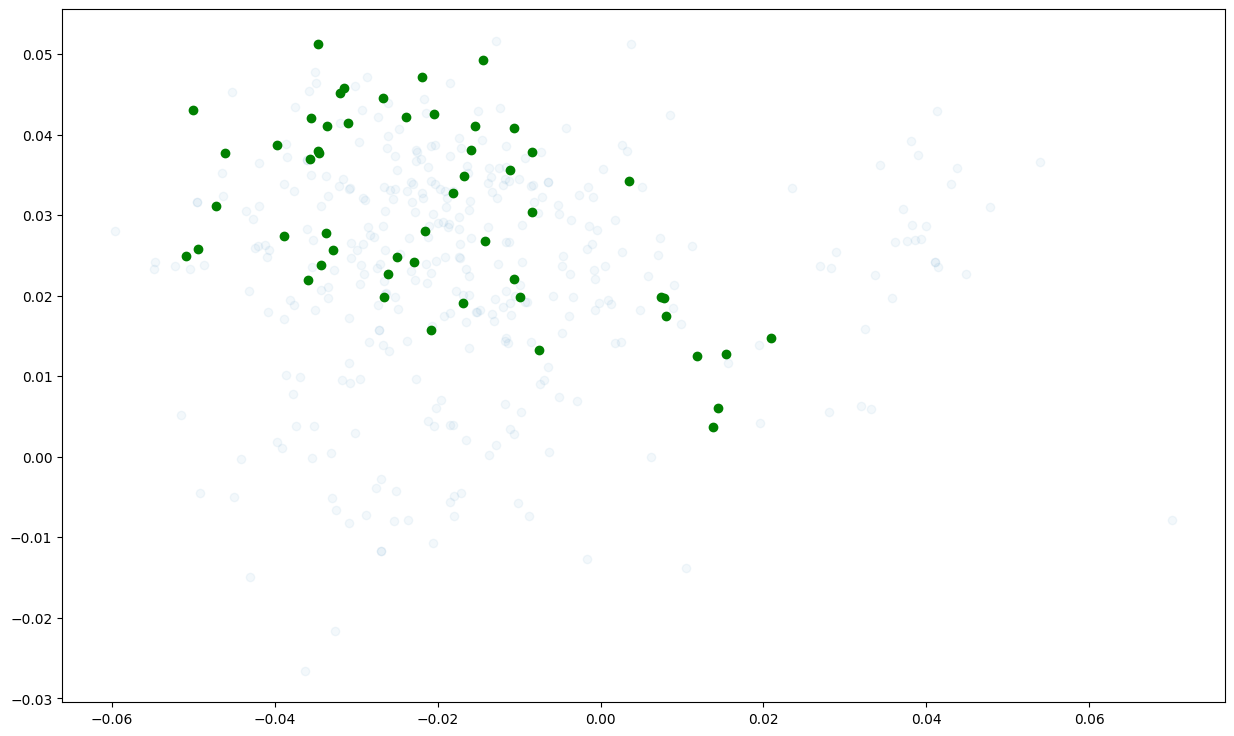

In [82]:
# This and several other helper functions are defined in a code cell above. Hit the "code"
# button above if you're curious about how they're implemented.
pattern = 'plan'
plot_by_title_pattern(pattern, figsize=(15, 9), bg_alpha=.05, text=False);




In [62]:
df

,uri,attributes,embeddings,x,y
0,gs://ml-demo-384110-bucket/dataset/immo/images...,"Plant, Sky, Cloud, Natural landscape, Tree, La...","[-0.015282416716217995, 0.017980653792619705, ...",-0.015282,0.017981
1,gs://ml-demo-384110-bucket/dataset/immo/images...,"Plant, Sky, Land lot, Grass, Tree, Road surfac...","[-0.011368189938366413, 0.01413376908749342, -...",-0.011368,0.014134
2,gs://ml-demo-384110-bucket/dataset/immo/images...,"Plant, Building, Sky, Property, Window, Cloud,...","[-0.022509198635816574, 0.037782903760671616, ...",-0.022509,0.037783
3,gs://ml-demo-384110-bucket/dataset/immo/images...,"Plant, Sky, Cloud, Property, Road surface, Nat...","[-0.019706012681126595, 0.033235084265470505, ...",-0.019706,0.033235
4,gs://ml-demo-384110-bucket/dataset/immo/images...,"Parallel, Font, Rectangle","[0.04484358802437782, 0.022739775478839874, 0....",0.044844,0.022740
...,...,...,...,...,...
395,gs://ml-demo-384110-bucket/dataset/immo/images...,"Property, Furniture, Couch, Wood, Comfort, Pic...","[-0.012336433865129948, 0.043270424008369446, ...",-0.012336,0.043270
396,gs://ml-demo-384110-bucket/dataset/immo/images...,"Table, Furniture, Building, Plant, Chair, Hous...","[-0.026628784835338593, 0.019807033240795135, ...",-0.026629,0.019807
397,gs://ml-demo-384110-bucket/dataset/immo/images...,"Furniture, Property, Window, Building, Azure, ...","[-0.022663148120045662, 0.00964480359107256, 0...",-0.022663,0.009645
398,gs://ml-demo-384110-bucket/dataset/immo/images...,"Window, Table, Furniture, Fixture, Wood, Inter...","[-0.009784757159650326, 0.005495359655469656, ...",-0.009785,0.005495


In [6]:
text_embedding(["What is life?", "What is "])

Length of Embedding Vector: 768
Length of Embedding Vector: 768


[-0.030642060562968254,
 0.048686955124139786,
 -0.007949741557240486,
 0.05337630584836006,
 0.03679315745830536,
 -0.002174903405830264,
 0.0772097036242485,
 0.030251048505306244,
 0.013593989424407482,
 0.00875870231539011,
 -0.023175783455371857,
 -0.013012902811169624,
 0.03764049708843231,
 0.009695491753518581,
 -0.03329642489552498,
 -0.03276855871081352,
 -0.017861811444163322,
 -0.049470312893390656,
 0.03382069990038872,
 -0.006983890663832426,
 -0.06539975106716156,
 0.0045309788547456264,
 -0.021828822791576385,
 -0.020136592909693718,
 -0.023238567635416985,
 -0.10309674590826035,
 0.009580624289810658,
 -0.019493594765663147,
 -0.044696833938360214,
 -0.04165506735444069,
 0.03480236977338791,
 -0.01007569208741188,
 -0.019895777106285095,
 -0.026880063116550446,
 -0.043962523341178894,
 0.04163392260670662,
 -0.04370066523551941,
 -0.010836956091225147,
 0.03934083133935928,
 -0.0028347219340503216,
 0.02945801615715027,
 -0.008018525317311287,
 0.030224770307540894,
 